<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COVID-19 Workaround 

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# download updated data
# repository italy https://github.com/pcm-dpc/COVID-19/tree/master/dati-andamento-nazionale
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url_csv_file)

In [314]:
df.head() # show firt lines of downloded data

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695


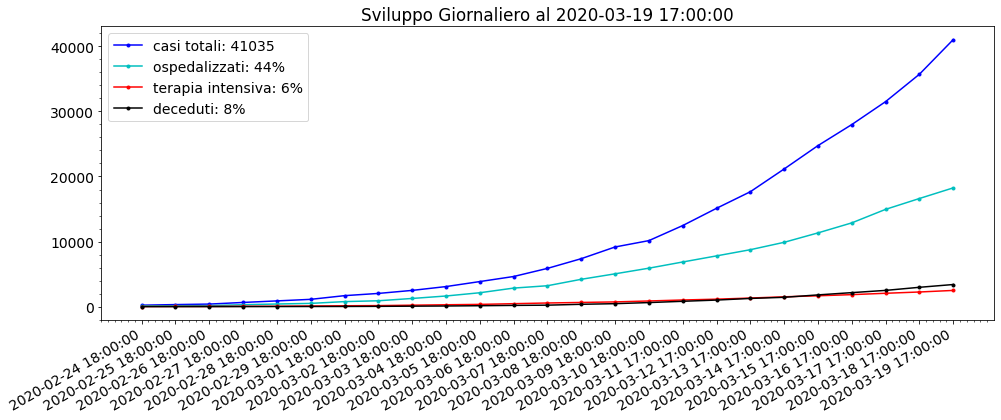

In [315]:
# visualize Daly data of infected and death people
plt.style.use('fast')
plt.rc('font', size = 14, family ='Sans-Serif')
fig, ax = plt.subplots(figsize=(16,6))
fig.autofmt_xdate()
ax.plot(df['data'], df['totale_casi'], 'b.-', label='casi totali: '+str(np.array(df['totale_casi'])[-1]))
perc_ospedalizzati = 100*np.array(df['totale_ospedalizzati'])[-1]/np.array(df['totale_casi'])[-1]
ax.plot(df['data'], df['totale_ospedalizzati'], 'c.-', label='ospedalizzati: {0:.0f}%'.format(perc_ospedalizzati))
perc_intensiva = 100*np.array(df['terapia_intensiva'])[-1]/np.array(df['totale_casi'])[-1]
ax.plot(df['data'], df['terapia_intensiva'], 'r.-', label='terapia intensiva: {0:.0f}%'.format(perc_intensiva))
perc_deceduti = 100*np.array(df['deceduti'])[-1]/np.array(df['totale_casi'])[-1]
ax.plot(df['data'], df['deceduti'], 'k.-', label='deceduti: {0:.0f}%'.format(perc_deceduti))
#ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Sviluppo Giornaliero al '+str(np.array(df['data'])[-1]))
#ax.set_yscale('log')
ax.legend(loc=2)
plt.minorticks_on()
plt.show()

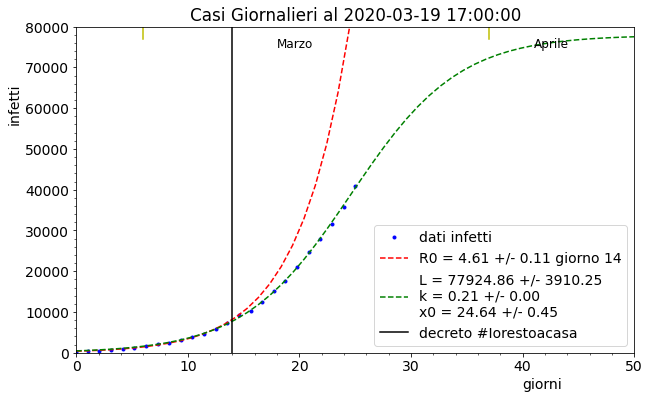

In [316]:
def Exp(x, p0, p1): # negative exponential

    import numpy as np
    return p0*np.exp(x/p1)

def Logistic(x, L, k, x0):
    return L / (1. + np.exp(-k * (x - x0)))

def Gompertz(x, a, b, c):
# https://en.wikipedia.org/wiki/Gompertz_function
    return a * np.exp(-b * np.exp(-c * x))


from scipy.optimize import curve_fit
x = np.linspace(0, len(df['data']), len(df['data']))

max_exp_fit = 14
popt_e,pcov_e = curve_fit(Exp,x[x<max_exp_fit], df['totale_casi'][x<max_exp_fit], p0=[1,2])
perr_e = np.sqrt(np.diag(pcov_e))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, df['totale_casi'], 'b.', label='dati infetti')
popt_l,pcov_l = curve_fit(Logistic,x, df['totale_casi'], p0=[4000.,4., 10.])
perr_l = np.sqrt(np.diag(pcov_l))
x=np.linspace(0,50,50)
ax.plot(x, Exp(x, *popt_e), 'r--', label='R0 = {0:.2f} +/- {1:.2f} giorno {2:d}'.format(popt_e[1], perr_e[1], max_exp_fit))
ax.plot(x, Logistic(x, *popt_l), 'g--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l[0], perr_l[0], popt_l[1], perr_l[1], popt_l[2], perr_l[2]))
ax.set_xlim(0,50)
ax.set_ylim(0,80000)
ax.plot([14,14], [0,80000], 'k-', label='decreto #Iorestoacasa')
ax.plot([6,6], [77000,80000], 'y-')
ax.plot([6+31,6+31], [77000,80000], 'y-')
ax.text(6+35, 75000, 'Aprile', fontsize=12)
ax.text(6+12, 75000, 'Marzo', fontsize=12)
ax.set_title('Casi Giornalieri al '+str(np.array(df['data'])[-1]))
ax.legend(loc=4)
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('infetti', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()


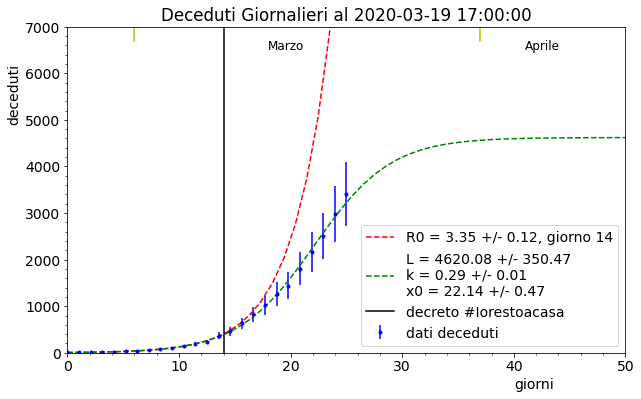

In [317]:
x = np.linspace(0, len(df['data']), len(df['data']))
# confronto con la Gompertz
max_exp_fit = 14
popt_e,pcov_e = curve_fit(Exp,x[x<max_exp_fit], df['deceduti'][x<max_exp_fit], p0=[1,2])
perr_e = np.sqrt(np.diag(pcov_e))
fig, ax = plt.subplots(figsize=(10,6))
err = df['deceduti']/np.sqrt(len(df['deceduti']))
ax.errorbar(x, df['deceduti'], yerr=err, fmt='b.', label='dati deceduti')
min_log_fit = 8
popt_l,pcov_l = curve_fit(Logistic,x[x>min_log_fit], df['deceduti'][x>min_log_fit], 
                          p0=[4000.,4., 10.], sigma=err[x>min_log_fit])
perr_l = np.sqrt(np.diag(pcov_l))
x=np.linspace(0,50,50)
ax.plot(x, Exp(x, *popt_e), 'r--', label='R0 = {0:.2f} +/- {1:.2f}, giorno {2:d}'.format(popt_e[1], perr_e[1], max_exp_fit))
ax.plot(x, Logistic(x, *popt_l), 'g--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l[0], perr_l[0], popt_l[1], perr_l[1], popt_l[2], perr_l[2]))
#ax.set_yscale('log')
ax.set_xlim(0,50)
ax.set_ylim(0,7000)
ax.plot([14,14], [0,7000], 'k-', label='decreto #Iorestoacasa')
ax.plot([6,6], [6700,7000], 'y-')
ax.plot([6+31,6+31], [6700,7000], 'y-')
ax.text(6+35, 6500, 'Aprile', fontsize=12)
ax.text(6+12, 6500, 'Marzo', fontsize=12)
ax.legend(loc=4)
ax.set_title('Deceduti Giornalieri al '+str(np.array(df['data'])[-1]))
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('deceduti', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()

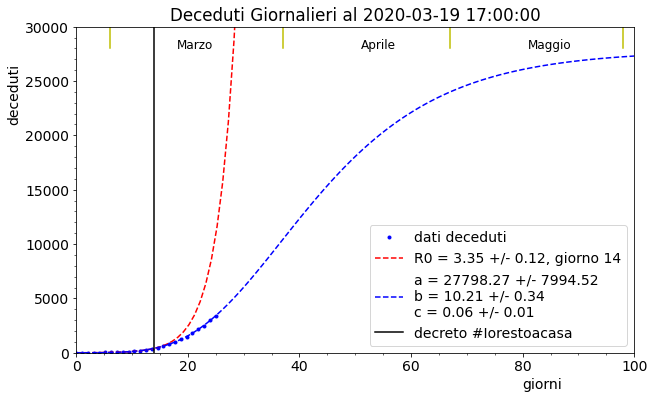

In [318]:
x = np.linspace(0, len(df['data']), len(df['data']))
# confronto con la Gompertz
max_exp_fit = 14
popt_e,pcov_e = curve_fit(Exp,x[x<max_exp_fit], df['deceduti'][x<max_exp_fit], p0=[1,2])
perr_e = np.sqrt(np.diag(pcov_e))
max_gom_fit = 12
popt_g,pcov_g = curve_fit(Gompertz,x[x>max_gom_fit], df['deceduti'][x>max_gom_fit], p0=[4500.,20., 0.01])
perr_g = np.sqrt(np.diag(pcov_g))

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, df['deceduti'], 'b.', label='dati deceduti')
x=np.linspace(0,100,100)
ax.plot(x, Exp(x, *popt_e), 'r--', label='R0 = {0:.2f} +/- {1:.2f}, giorno {2:d}'.format(popt_e[1], perr_e[1], max_exp_fit))
ax.plot(x, Gompertz(x, *popt_g), 'b--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}'.format(popt_g[0], perr_g[0], popt_g[1], perr_g[1], popt_g[2], perr_g[2]))


#ax.set_yscale('log')
ax.set_xlim(0,100)
ax.set_ylim(0,30000)
ax.plot([14,14], [0,30000], 'k-', label='decreto #Iorestoacasa')
ax.plot([6,6], [28000,30000], 'y-')
ax.plot([6+31,6+31], [28000,30000], 'y-')
ax.plot([6+31+30,6+31+30], [28000,30000], 'y-')
ax.plot([6+31+30+31,6+31+30+31], [28000,30000], 'y-')
ax.text(6+12, 28000, 'Marzo', fontsize=12)
ax.text(6+45, 28000, 'Aprile', fontsize=12)
ax.text(6+75, 28000, 'Maggio', fontsize=12)
ax.legend(loc=4)
ax.set_title('Deceduti Giornalieri al '+str(np.array(df['data'])[-1]))
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('deceduti', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()


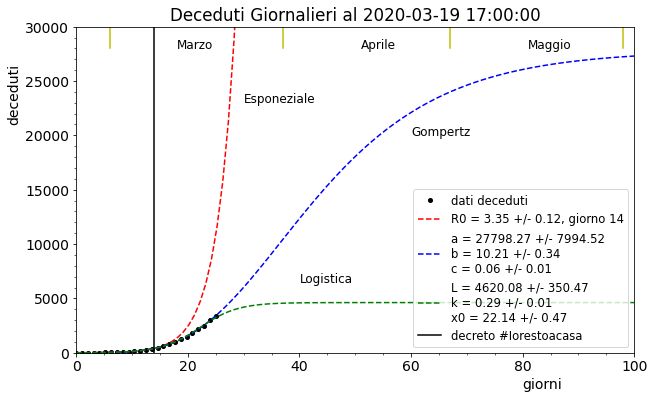

In [319]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, len(df['data']), len(df['data']))
ax.plot(x, df['deceduti'], 'k.', markersize=8, label='dati deceduti')
x=np.linspace(0,100,100)
ax.plot(x, Exp(x, *popt_e), 'r--', label='R0 = {0:.2f} +/- {1:.2f}, giorno {2:d}'.format(popt_e[1], perr_e[1], max_exp_fit))
ax.plot(x, Gompertz(x, *popt_g), 'b--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}'.format(popt_g[0], perr_g[0], popt_g[1], perr_g[1], popt_g[2], perr_g[2]))
ax.plot(x, Logistic(x, *popt_l), 'g--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l[0], perr_l[0], popt_l[1], perr_l[1], popt_l[2], perr_l[2]))

#ax.set_yscale('log')
ax.set_xlim(0,100)
ax.set_ylim(0,30000)
ax.plot([14,14], [0,30000], 'k-', label='decreto #Iorestoacasa')
ax.plot([6,6], [28000,30000], 'y-')
ax.plot([6+31,6+31], [28000,30000], 'y-')
ax.plot([6+31+30,6+31+30], [28000,30000], 'y-')
ax.plot([6+31+30+31,6+31+30+31], [28000,30000], 'y-')
ax.text(6+12, 28000, 'Marzo', fontsize=12)
ax.text(6+45, 28000, 'Aprile', fontsize=12)
ax.text(6+75, 28000, 'Maggio', fontsize=12)
ax.text(30, 23000, 'Esponeziale', fontsize=12)
ax.text(60, 20000, 'Gompertz', fontsize=12)
ax.text(40, 6500, 'Logistica', fontsize=12)
ax.legend(loc=4, prop={'size':'small'})
ax.set_title('Deceduti Giornalieri al '+str(np.array(df['data'])[-1]))
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('deceduti', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()


In [0]:
# world data
# https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-03-17.xlsx
# https://github.com/CSSEGISandData/COVID-19

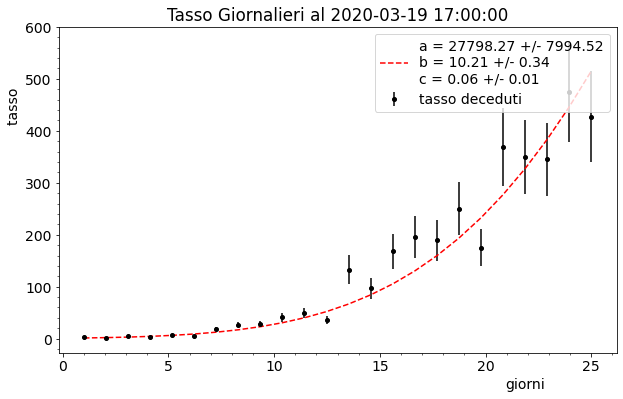

In [322]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(1, len(df['data']), len(df['data'])-1)
tasso_positivi = []
tasso_deceduti = []
for i in range(1, len(df['data'])):
  tasso_positivi.append(np.array(df['totale_casi'])[i]-np.array(df['totale_casi'])[i-1])
  tasso_deceduti.append(np.array(df['deceduti'])[i]-np.array(df['deceduti'])[i-1])
y = tasso_deceduti
yerr = y/np.sqrt(len(y))
ax.errorbar(x, y, yerr=yerr, fmt='k.', markersize=8, label='tasso deceduti')

popt_gd,pcov_gd = curve_fit(Gompertz,x, y, p0=[4500.,20., 0.01], sigma=yerr)
perr_gd = np.sqrt(np.diag(pcov_gd))

ax.plot(x, Gompertz(x, *popt_gd), 'r--', label='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
\nc = {4:.2f} +/- {5:.2f}'.format(popt_g[0], perr_g[0], popt_g[1], perr_g[1], popt_g[2], perr_g[2]))

#ax.set_xlim(500,100)
#ax.set_ylim(-500,500)
#ax.plot([14,14], [0,30000], 'k-', label='decreto #Iorestoacasa')
#ax.plot([6,6], [28000,30000], 'y-')
#ax.plot([6+31,6+31], [28000,30000], 'y-')
#ax.plot([6+31+30,6+31+30], [28000,30000], 'y-')
#ax.plot([6+31+30+31,6+31+30+31], [28000,30000], 'y-')
#ax.text(6+12, 28000, 'Marzo', fontsize=12)
#ax.text(6+45, 28000, 'Aprile', fontsize=12)
#ax.text(6+75, 28000, 'Maggio', fontsize=12)
ax.legend(loc=1)
ax.set_title('Tasso Giornalieri al '+str(np.array(df['data'])[-1]))
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('tasso ', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()


In [323]:
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
dr = pd.read_csv(url_csv_file)
dr.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,5
1,2020-02-24 18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0
2,2020-02-24 18:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,1
3,2020-02-24 18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,1
4,2020-02-24 18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,10


In [324]:
dr[['tamponi', 'denominazione_regione']]


,tamponi,denominazione_regione
0,5,Abruzzo
1,0,Basilicata
2,1,P.A. Bolzano
3,1,Calabria
4,10,Campania
...,...,...
520,8873,Toscana
521,2203,P.A. Trento
522,1954,Umbria
523,608,Valle d'Aosta


In [325]:
dr.loc[(dr['denominazione_regione'] == 'Lazio') & (dr['data'] == '2020-03-18 17:00:00')]['tamponi']
dr.loc[(dr['denominazione_regione'] == 'Puglia') & (dr['data'] == '2020-03-18 17:00:00')]['tamponi'].values

array([3433])

In [0]:
P_Lazio = 5.897e6
P_Campania = 5.827e6
P_Abruzzo = 1.315e6
P_Puglia = 4.048e6

In [0]:
y = [(10000*dr.loc[(dr['denominazione_regione'] == 'Lazio') & (dr['data'] == '2020-03-18 17:00:00')]['tamponi'].values/P_Lazio)[0],
     (10000*dr.loc[(dr['denominazione_regione'] == 'Campania') & (dr['data'] == '2020-03-18 17:00:00')]['tamponi'].values/P_Campania)[0],
     (10000*dr.loc[(dr['denominazione_regione'] == 'Abruzzo') & (dr['data'] == '2020-03-18 17:00:00')]['tamponi'].values/P_Abruzzo)[0],
     (10000*dr.loc[(dr['denominazione_regione'] == 'Puglia') & (dr['data'] == '2020-03-18 17:00:00')]['tamponi'].values/P_Puglia)[0]
     ]

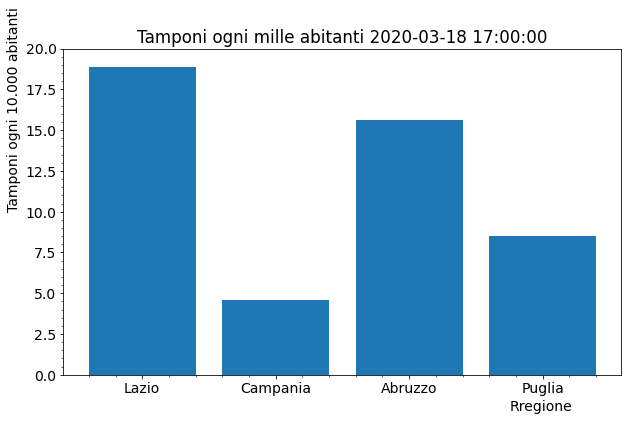

In [224]:
fig, ax = plt.subplots(figsize=(10,6))
xl = ['Lazio', 'Campania', 'Abruzzo', 'Puglia']
x = [0,1,2,3]
#ax.plot(xl, y, linestyle='dashed')
ax.bar(xl, y)
#ax.set_xticks(x, xl)
ax.set_ylim(0, 20)
ax.set_title('Tamponi ogni mille abitanti '+str(np.array(df['data'])[-1]))
ax.set_xlabel('Rregione', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('Tamponi ogni 10.000 abitanti', horizontalalignment = 'left', y=0.5)
plt.minorticks_on()
plt.show()

In [225]:
url_csv_file = "https://docs.google.com/spreadsheet/ccc?key=1qL5B_J6eV6bD9zicR0YsCIaUMU0BhTdSTrqC1UcDBI8&output=csv"
dpr = pd.read_csv(url_csv_file)
dpr.head()

,Regione,Popolazione,Superficie,Densità,Comuni,Province
0,Lombardia,10060.574,23863.65,422,1506,12
1,Lazio,5879.082,17232.29,341,378,5
2,Campania,5801.692,13670.95,424,550,5
3,Sicilia,4999.891,25832.39,194,390,9
4,Veneto,4905.854,18345.35,267,563,7


In [0]:

perc_tamponi = []
perc_positivi = []
perc_deceduti = []
for r in range(0, len(regioni)):
  if regioni[r]=='Trentino Alto Adige':
    popolazione = float(dpr.loc[dpr['Regione']=='Trentino Alto Adige']['Popolazione'].values[0])*1e3
    tamponi = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == '2020-03-18 17:00:00')]['tamponi'].values[0]
    tamponi = tamponi + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == '2020-03-18 17:00:00')]['tamponi'].values[0]
    perc_tamponi.append(tamponi/popolazione)
    positivi = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == '2020-03-18 17:00:00')]['totale_casi'].values[0]
    positivi = positivi + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == '2020-03-18 17:00:00')]['totale_casi'].values[0]
    perc_positivi.append(positivi/popolazione)
    deceduti = 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Trento' ) & (dr['data'] == '2020-03-18 17:00:00')]['deceduti'].values[0]
    deceduti = deceduti + 10000*dr.loc[(dr['denominazione_regione'] == 'P.A. Bolzano' ) & (dr['data'] == '2020-03-18 17:00:00')]['deceduti'].values[0]
    perc_deceduti.append(deceduti/popolazione)

  else:
    popolazione = float(dpr.loc[dpr['Regione']==regioni[r]]['Popolazione'].values[0])*1e3
    tamponi = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == '2020-03-18 17:00:00')]['tamponi'].values[0]
    perc_tamponi.append(tamponi/popolazione)
    positivi = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == '2020-03-18 17:00:00')]['totale_casi'].values[0]
    perc_positivi.append(positivi/popolazione)
    deceduti = 10000*dr.loc[(dr['denominazione_regione'] == regioni[r] ) & (dr['data'] == '2020-03-18 17:00:00')]['deceduti'].values[0]
    perc_deceduti.append(deceduti/popolazione)


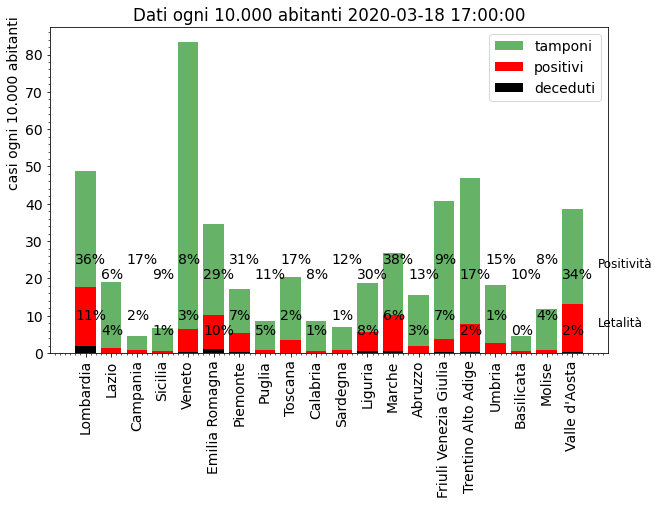

In [300]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(regioni, perc_tamponi, label='tamponi', alpha=0.6, color='green')
ax.bar(regioni, perc_positivi, label='positivi', color='red')
ax.bar(regioni, perc_deceduti, label='deceduti', color='black')
#ax.set_ylim(0, 20)
ax.set_title('Dati ogni 10.000 abitanti '+str(np.array(df['data'])[-1]))
#ax.set_xlabel('Rregione', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('casi ogni 10.000 abitanti', horizontalalignment = 'left', y=0.5)
for i in range(regioni.size):
  if i % 2 == 0:
    offset = 4
  else:
    offset = 0
  plt.annotate('{:.0f}%'.format(100*perc_positivi[i]/perc_tamponi[i]), (i-0.4,20+offset))
  plt.annotate('{:.0f}%'.format(100*perc_deceduti[i]/perc_positivi[i]), (i-0.4,5+offset))
#ax.set_yscale('log')
ax.text(20, 7, 'Letalità', fontsize=12)
ax.text(20, 23, 'Positività', fontsize=12)
plt.xticks(rotation=90)
plt.minorticks_on()
plt.legend()
plt.show()

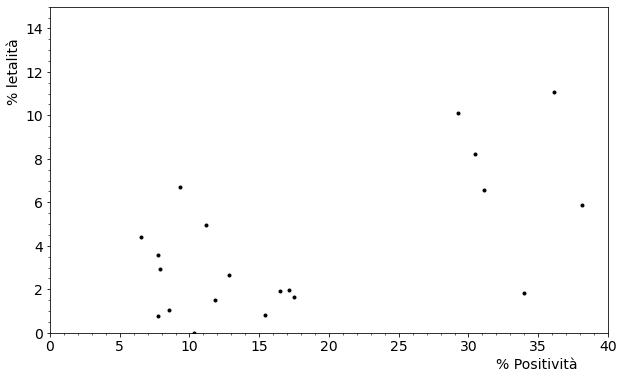

In [312]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(100*np.array(perc_positivi)/np.array(perc_tamponi), 100*np.array(perc_deceduti)/np.array(perc_positivi), 'k.')
plt.minorticks_on()
ax.set_xlim(0,40)
ax.set_ylim(0,15)
ax.set_xlabel('% Positività', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('% letalità', horizontalalignment = 'left', y=0.7)
plt.show()